# PCA Rolling OLS Regression

Here is what is known so far <br>
1. Trading conditioned on Citi Surprise Indices ```IndexBacktest.ipynb``` seems to work for some Citi Surprise Indices (G10, Major Economies)
2. Trading conditioned on PCs of Citi Surprise Indices ```PCARawBacktest.ipynb``` seems to underperform but still beats out their index (in terms of sharpe), from an OLS standpoint the indicator is not ideal ```PCASignOLS.ipynb``` 
3. Trading conditioned on being long the residuals of regressing the PCs of the Citi Surprise Indices ```PCAOLSBacktest.ipynb``` against the Index Returns seems to work much better (from a full sample standpoint). But from an OLS standpoint the regression shows that indicator is not ideal ```PCAOLS.ipynb```
4. Extending the analysis from above using a OLS generated from random sub-samples ```PCABoostrappedOLSBacktest.ipynb``` still shows that the performance is still strong even under the randomized subsample

## Rolling Approach

In this case there was a strong performance in the sub-sampled OLS (boostrapped). The sub-sample is more realistic than the in-sample full-sample but it introduces look-ahead bias. This notebook will avoid lookahead bias by using a rolling beta. The same approach will be used where each model is for the rank of the matrix and includes all the PCs in that rank (i.e. 10th PC model is a multivaraite 10 variable regression not a regression of the 10th PC solely) <br>

Since the overall goal is to find a model that reaches an in-sample in this case its going to be an expanding window

## Packages

In [1]:
import os
import sys
import math
import numpy as np
import pandas as pd

import statsmodels.api as sm
from   statsmodels.regression.rolling import RollingOLS

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

from tqdm import tqdm
tqdm.pandas()

In [2]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/FXCarryEconomicSurprise/root/src")
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FXCarryCitiSurprise\root\src")
from CitiPCA import PCAModel

# Attempt 1

In [3]:
def _rolling_ols(df: pd.DataFrame, pcs: list) -> pd.DataFrame:
    
    model = (RollingOLS(
        endog     = df.FXCARRSP,
        exog      = sm.add_constant(df[pcs]),
        expanding = True).
        fit())
    
    df_tmp = (df.reset_index().melt(
        id_vars = ["date", "FXCARRSP"]).
        rename(columns = {"value": "pc_val"}))
    
    df_out = (model.params.reset_index().rename(
        columns = {"const": "alpha"}).
        melt(id_vars = ["date", "alpha"]).
        rename(columns = {"value": "beta_val"}).
        merge(right = df_tmp, how = "inner", on = ["date", "variable"]).
        dropna().
        assign(regress = pcs[-1]))
    
    return df_out

def get_regression() -> pd.DataFrame: 

    df_pcs = (PCAModel().pca().drop(
        columns = ["explained_variance_ratio"]))

    df_carry = (PCAModel().get_misc_indices().query(
        "security == 'FXCARRSP'").
        pivot(index = "date", columns = "security", values = "rtn").
        dropna())
    
    max_pcs = df_pcs.pc.str.replace("PC", "").astype(int).max()
    df_out  = pd.DataFrame()

    for i in range(max_pcs):

        pcs         = ["PC{}".format(j + 1) for j in range(i + 1)]
        df_combined = (df_pcs.query(
            "pc == @pcs").
            pivot(index = "date", columns = "pc", values = "value").
            merge(right = df_carry, how = "inner", on = ["date"]))

        df_out = pd.concat([df_out, _rolling_ols(df_combined, pcs)])
        
    return df_out
    

df_regression = get_regression()

C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encount

In [4]:
def _get_resid(df: pd.DataFrame) -> pd.DataFrame:
    
    df_out = (df.pivot(
        index = ["date", "alpha", "FXCARRSP", "regress"], columns = "variable", values = "beta_scaled").
        reset_index().
        set_index(["date", "FXCARRSP", "regress"]).
        sum(axis = 1).
        to_frame(name = "predict").
        reset_index().
        sort_values("date").
        assign(
            resid     = lambda  x: x.predict - x.FXCARRSP,
            lag_resid = lambda  x: x.resid.shift(),
            signal_rtn = lambda x: np.sign(x.lag_resid) * x.FXCARRSP))
    
    return df_out

def get_resid(df_regression: pd.DataFrame) -> pd.DataFrame:   

    df_out = (df_regression.assign(
        beta_scaled = lambda x: x.beta_val * x.pc_val).
        groupby("regress").
        apply(_get_resid).
        reset_index(drop = True))
    
    return df_out

df_resid = get_resid(df_regression)

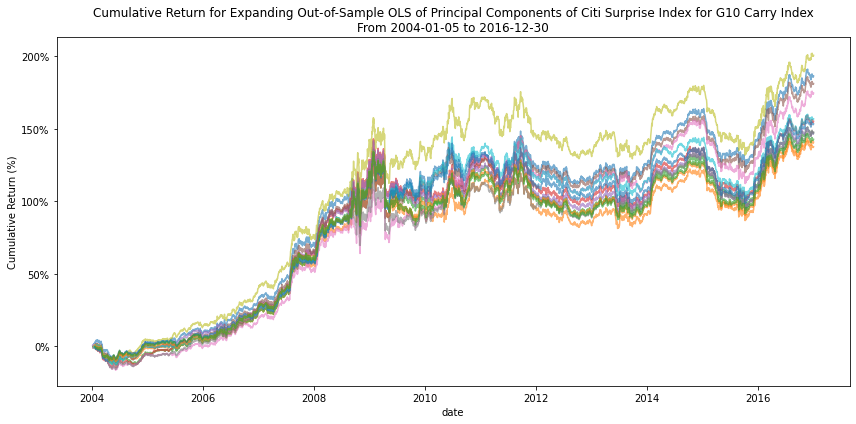

In [5]:
def plot_cumulative_return(df_resid: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (12,6))

    (df_resid.pivot(
        index = "date", columns = "regress", values = "signal_rtn").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            legend = False, 
            ax     = axes,
            alpha  = 0.6,
            ylabel = "Cumulative Return (%)",
            title  = "Cumulative Return for Expanding Out-of-Sample OLS of Principal Components of Citi Surprise Index for G10 Carry Index\nFrom {} to {}".format(
                    df_resid.date.min(),
                    df_resid.date.max())))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    plt.tight_layout()
    
plot_cumulative_return(df_resid)

In [6]:
def get_sharpe(df_resid: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe = (df_resid.pivot(
        index = ["date", "FXCARRSP"], columns = "regress", values = "signal_rtn").
        reset_index().
        melt(id_vars = "date").
        drop(columns = ["date"]).
        groupby("regress").
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)))
    
    return df_sharpe

df_sharpe = get_sharpe(df_resid)

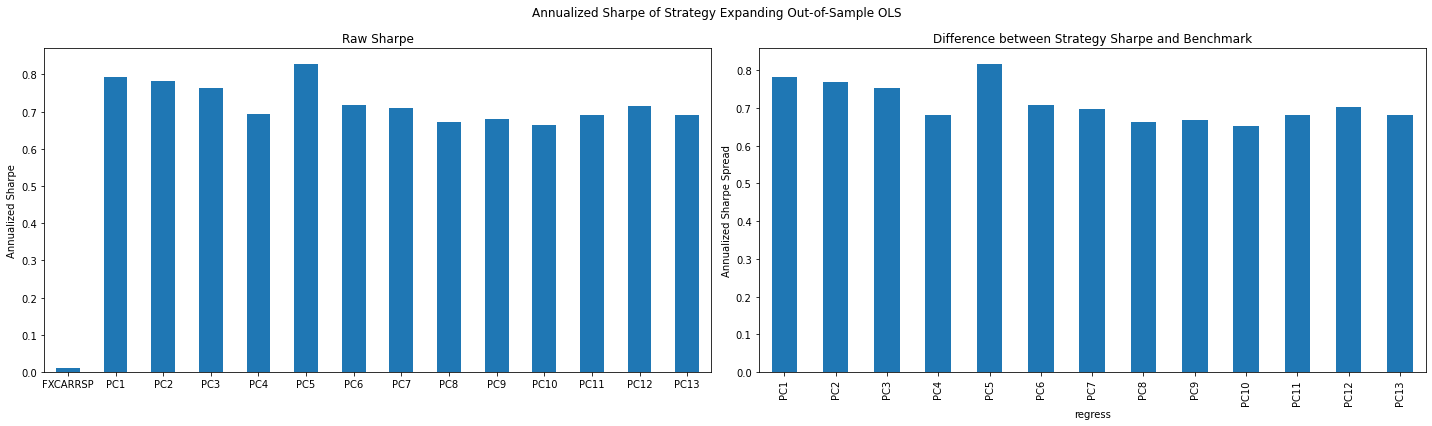

In [7]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    df_tmp = (df_sharpe.reset_index().assign(
        order = lambda x: np.where(x.regress == "FXCARRSP", 0, x.regress.str.replace("PC", "")).astype(int)).
        sort_values("order"))

    (df_tmp.set_index(
        "regress")
        [["sharpe"]].
        plot(
            ax      = axes[0],
            kind    = "bar",
            legend  = False,
            xlabel  = "",
            rot     =  0,
            ylabel  = "Annualized Sharpe",
            title   = "Raw Sharpe"))

    (df_tmp[
        ["regress", "sharpe"]].
        set_index("regress").
        T.
        melt(id_vars = "FXCARRSP").
        assign(spread = lambda x: x.value - x.FXCARRSP).
        set_index("regress")
        [["spread"]].
        plot(
            ax     = axes[1],
            kind   = "bar",
            legend = False,
            ylabel = "Annualized Sharpe Spread",
            title  =  "Difference between Strategy Sharpe and Benchmark"))

    fig.suptitle("Annualized Sharpe of Strategy Expanding Out-of-Sample OLS")
    plt.tight_layout()
    
plot_sharpe(df_sharpe)